In [ ]:
%load_ext autoreload
%autoreload 2

# Learning Sepsis Policies

In this notebook, we learn two policies which solve the sepsis environment, one for AI agent and one for human clinician.

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import mdptoolbox as mdp
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from typing import List
from matplotlib.ticker import FormatStrFormatter
from rich.jupyter import print

In [4]:
from ced.actors.sepsis import SepsisActor, SepsisAction, ClinicianActor, AIActor
from ced.envs.sepsis import Sepsis, SepsisTrajectory, State
from ced.tools.utils import sample_trajectories, export_legend
from ced.tools.order import Order
from ced.tools.noise import UniformNoiseModel, SepsisStateUniformNoiseModel

In [5]:
_ = sns.set_theme(
    style="white", context="paper",
    palette="muted",
    rc={
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 25,
        "axes.titlesize": 25,
        "axes.labelsize": 25,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 20,
        "legend.columnspacing": 1,
        "legend.title_fontsize": 20,
        "figure.figsize": (6.4, 6.4),
    },
)

In [6]:
seed = 5592
max_horizon = 20
discount = 0.99
rng = np.random.default_rng(seed)

ai_policy_path = Path("./results/sepsis/ai_policy.pkl")
cl_policy_path = Path("./results/sepsis/cl_policy.pkl")

original_mdp_path = Path("./results/sepsis/mdp_original.pkl")
ai_mdp_path = Path("./results/sepsis/mdp_ai.pkl")
cl_mdp_path = original_mdp_path

plots_dir = Path("./plots/sepsis")

palette = {"AI": "#ffa743", "Clinician": "#cd4e24", "Random": "#cc8926", "no change": "#e69a2b", "death": "#e61a34", "discharge": "#009622"}

plt_skip_legend = True

plt_discrepancy_title = None
plt_discrepancy_legend_title = None
plt_discrepancy_x_label = "Action"
plt_discrepancy_y_label = "Probability"

plt_rewards_title = None
plt_rewards_x_label = "Policy"
plt_rewards_y_label = "Fraction of Outcomes"
plt_rewards_legend_title = None

In [7]:
def get_stats(trajectories: List[SepsisTrajectory]):
    return {
        "success": sum([bool(t.outcome() == 1.0) for t in trajectories]),
        "failure": sum([bool(t.outcome() != 1.0) for t in trajectories]),
        "total": len(trajectories),
    }

## Random Actor

To have a baseline agent to compare learned policies to, we first examine the performance of a random agent.

In [8]:
env = Sepsis(transition_probabilities="./assets/sepsis/sepsis_transition_probs_original.json", max_horizon=max_horizon)
actor_cl = SepsisActor(id=0, rng=rng)
trajectories = sample_trajectories(env=env, agents=[actor_cl], num_trajectories=100, rng=rng)
stats = get_stats(trajectories)
rew_values, rew_counts = np.unique([sum([s.reward for s in t.states]) for t in trajectories], return_counts=True)

In [9]:
print(f"Random agent achieved [bold]{stats['success']}[/] successes and [bold]{stats['failure']}[/] failures in [bold]{stats['success'] + stats['failure']}[/] trajectories.")
print(f"Random agent achieved rewards {rew_values.tolist()} (death, max horizon reached, survival) with frequency {rew_counts.tolist()}")

Random agent achieved 22 successes and 78 failures in 100 trajectories.

Random agent achieved rewards [-1.0, 0.0, 1.0] (death, max horizon reached, survival) with frequency [78, 16, 6]

## Human Clinician

We learn the human clinician using the original transition probabilities of the environment. This ensures that the quality of the human policy is high.

We start by loading the transition and reward matrices from the exported file (see `learn_sepsis_mdp.ipynb` notebook for the export procedure).

In [10]:
with open(cl_mdp_path, "rb") as f:
    mdp_dynamics_cl = pickle.load(f)
    P, R = mdp_dynamics_cl["transition_matrix"], mdp_dynamics_cl["reward_matrix"]

Next, we run the policy iteration algorithm to find the optimal policy.

In [11]:
if not cl_policy_path.exists():
    Pi = mdp.mdp.PolicyIteration(P, R, discount=discount, eval_type=1)
    Pi.run()

We convert the policy to matrix form, where each row represents a one-hot vector pointing to the action to be taken and save it to disk.

In [12]:
if not cl_policy_path.exists():
    policy = np.zeros((State.NUM_TOTAL, SepsisAction.NUM_TOTAL))
    policy[np.arange(len(Pi.policy)), Pi.policy] = 1
    with open(cl_policy_path, "wb") as f: pickle.dump(policy, f)

Finally, we can create an actor that utilizes the learned policy and examine its performance in the environment. Note that we always evaluate the actors on the original MDP.

In [13]:
act_noise = UniformNoiseModel(order=Order([i for i in range(SepsisAction.NUM_TOTAL)]))
env_noise = SepsisStateUniformNoiseModel(order=Order([i for i in range(State.NUM_TOTAL)]))
env = Sepsis(dynamics=original_mdp_path, max_horizon=max_horizon, act_noise_model=act_noise, env_noise_model=env_noise)
actor_cl = SepsisActor(id=0, policy=cl_policy_path, rng=rng)
trajectories = sample_trajectories(env=env, agents=[actor_cl], num_trajectories=100, rng=rng)
stats = get_stats(trajectories)
rew_values, rew_counts = np.unique([sum([s.reward for s in t.states]) for t in trajectories], return_counts=True)

In [14]:
print(f"Clinician achieved [bold]{stats['success']}[/] successes and [bold]{stats['failure']}[/] failures in [bold]{stats['success'] + stats['failure']}[/] trajectories.")
print(f"Clinician achieved rewards {rew_values.tolist()} (death, max horizon reached, survival) with frequency {rew_counts.tolist()}")

Clinician achieved 94 successes and 6 failures in 100 trajectories.

Clinician achieved rewards [-1.0, 0.0, 1.0] (death, max horizon reached, survival) with frequency [6, 33, 61]

## AI Policy

Using the exact same procedure as the for human clinician, we learn the AI policy. However, instead of using the original probabilities, we utilize an alternative set of probabilities intended to make the AI policy different to the human policy (see also `learn_sepsis_mdp.ipynb` for details). Apart from the the next cell (which loads different transition matrix), remainder of the process is equivalent to what we've done so far.

In [15]:
with open(ai_mdp_path, "rb") as f:
    mdp_dynamics_ai = pickle.load(f)
    P, R = mdp_dynamics_ai["transition_matrix"], mdp_dynamics_ai["reward_matrix"]

In [16]:
if not ai_policy_path.exists():
    Pi = mdp.mdp.PolicyIteration(P, R, discount=discount, eval_type=1)
    Pi.run()

In [17]:
if not ai_policy_path.exists():
    policy = np.zeros((State.NUM_TOTAL, SepsisAction.NUM_TOTAL))
    policy[np.arange(len(Pi.policy)), Pi.policy] = 1
    with open(ai_policy_path, "wb") as f: pickle.dump(policy, f)

In [18]:
act_noise = UniformNoiseModel(order=Order([i for i in range(SepsisAction.NUM_TOTAL)]))
env_noise = SepsisStateUniformNoiseModel(order=Order([i for i in range(State.NUM_TOTAL)]))
env = Sepsis(dynamics=original_mdp_path, max_horizon=max_horizon, act_noise_model=act_noise, env_noise_model=env_noise) # we evaluate the actor using the original environment dynamics
actor_ai = SepsisActor(id=0, policy=ai_policy_path, rng=rng)
trajectories = sample_trajectories(env=env, agents=[actor_ai], num_trajectories=100, rng=rng)
stats = get_stats(trajectories)
rew_values, rew_counts = np.unique([sum([s.reward for s in t.states]) for t in trajectories], return_counts=True)

In [19]:
print(f"AI achieved [bold]{stats['success']}[/] successes and [bold]{stats['failure']}[/] failures in [bold]{stats['success'] + stats['failure']}[/] trajectories.")
print(f"AI achieved rewards {rew_values.tolist()} (death, max horizon reached, survival) with frequency {rew_counts.tolist()}")

AI achieved 96 successes and 4 failures in 100 trajectories.

AI achieved rewards [-1.0, 0.0, 1.0] (death, max horizon reached, survival) with frequency [4, 48, 48]

## Comparison of Policies

To better understand if and how two policies differ, we perform a brief analysis.

In [20]:
actions_ai = actor_ai.policy_map.argmax(axis=-1)
actions_cl = actor_cl.policy_map.argmax(axis=-1)
actions_diff = (actions_ai != actions_cl).astype(int).mean()
print(f"There is {actions_diff * 100:.2f}% difference in actions taken by clinician and AI policies.")

There is 18.06% difference in actions taken by clinician and AI policies.

Continuing, we plot a histogram of actions for both AI and clinician policies, to visually inspect the observed difference. For each action (a combination of antibiotics (A), vasopressors (V) and ventilators (E)) we plot the number of times both policies select the respective action.

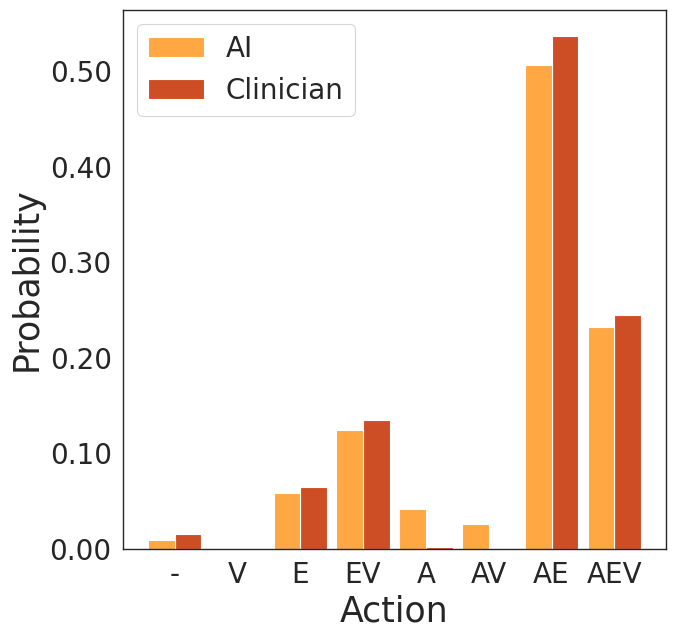

In [21]:
df_actions_ai = pd.DataFrame([{"policy": "AI", "action": actions_ai[i].item(), "state": i} for i in range(State.NUM_TOTAL)])
df_actions_cl = pd.DataFrame([{"policy": "Clinician", "action": actions_cl[i].item(), "state": i} for i in range(State.NUM_TOTAL)])

fig, ax = plt.subplots(figsize=(7, 7))
_ = sns.histplot(data=pd.concat([df_actions_ai, df_actions_cl]), x="action", stat="probability", hue="policy", multiple="dodge", shrink=0.85, palette=palette, discrete=True, alpha=1.0, cumulative=False, common_bins=False, common_norm=False, ax=ax)
_ = ax.set_xticks(range(SepsisAction.NUM_TOTAL), labels=[str(SepsisAction.from_index(i)) for i in range(SepsisAction.NUM_TOTAL)])
_ = ax.set_title(plt_discrepancy_title)
_ = ax.set_xlabel(plt_discrepancy_x_label)
_ = ax.set_ylabel(plt_discrepancy_y_label)
_ = ax.get_legend().set_title(plt_discrepancy_legend_title)
_ = ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# separately exports legend
if not plt_skip_legend:
    legend_fig, legend = export_legend(fig, ax)
    legend_fig.savefig(plots_dir / "plt_agents_discrepancy-legend.pdf", bbox_inches=legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[legend])

fig.savefig(plots_dir / "plt_agents_discrepancy.pdf", bbox_inches="tight")

## Evaluation of Policies

We record the mean reward of the AI and CL policies using the ground-truth simulator over 1000 sampled trajectories.

In [22]:
actor_ai = AIActor(id=0, policy=ai_policy_path, rng=rng)
actor_cl = ClinicianActor(id=0, policy=cl_policy_path, rng=rng)
actor_rd = SepsisActor(id=0, rng=rng)
env = Sepsis(transition_probabilities="./assets/sepsis/sepsis_transition_probs_original.json", max_horizon=max_horizon)
num_trajectories = 1000
discount = 1

In [23]:
trajectories_ai = sample_trajectories(env=env, agents=[actor_ai], num_trajectories=num_trajectories, rng=rng)
trajectories_cl = sample_trajectories(env=env, agents=[actor_cl], num_trajectories=num_trajectories, rng=rng)
trajectories_rd = sample_trajectories(env=env, agents=[actor_rd], num_trajectories=num_trajectories, rng=rng)
stats_ai, stats_cl, stats_rd = get_stats(trajectories_ai), get_stats(trajectories_cl), get_stats(trajectories_rd)

In [24]:
rewards_ai = [{"agent": "AI", "reward": t.total_reward(discount=discount)} for t in trajectories_ai]
rewards_cl = [{"agent": "Clinician", "reward": t.total_reward(discount=discount)} for t in trajectories_cl]
rewards_rd = [{"agent": "Random", "reward": t.total_reward(discount=discount)} for t in trajectories_rd]

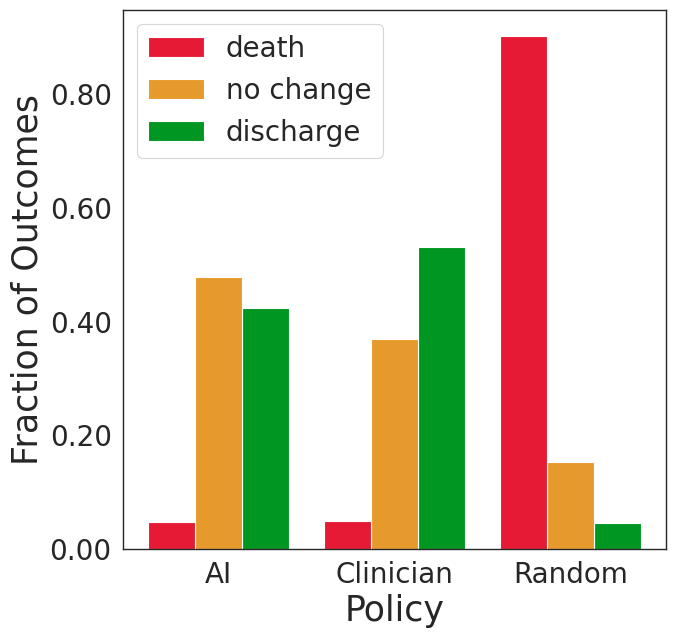

In [25]:
df = pd.DataFrame(rewards_ai + rewards_cl + rewards_rd)
df.reward = pd.Categorical(df.reward, categories=[-1.0, 0.0, +1.0]).rename_categories({-1.0: "death", 0.0: "no change", +1.0: "discharge"})
fig, ax = plt.subplots(figsize=(7, 7))
_ = sns.histplot(data=df, x="agent", hue="reward", palette=palette, multiple="dodge", stat="probability", shrink=0.8, alpha=1.0, ax=ax, discrete=True, cumulative=False, common_norm=False)
_ = ax.set_title(plt_rewards_title)
_ = ax.set_xlabel(plt_rewards_x_label)
_ = ax.set_ylabel(plt_rewards_y_label)
_ = ax.get_legend().set_title(plt_rewards_legend_title)
_ = ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.savefig(plots_dir / "plt_agents_observed_reward.pdf", bbox_inches="tight")